## Question 1: **Answer**

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
def add_data_to_database(input_data):
    try:
        # Creating a DataFrame
        df = pd.read_csv(input_data)
        # Connecting to database
        engine = sqlite3.connect("electronics_sales_data.db")
        df.to_sql("electronics", con=engine, index = False)
        engine.close()
    except Exception as e:
            print(f'Error: {e}')

# Loading data
input_data = "/content/Electronic_Sales.csv"
add_data_to_database(input_data)

In [3]:
# Loading Magic extension
%load_ext sql

In [4]:
# Connecting to the database
%sql sqlite:///electronics_sales_data.db

In [5]:
# Default to duplicated style
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [6]:
%%sql
SELECT * FROM electronics
LIMIT 5;

 * sqlite:///electronics_sales_data.db
Done.


Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total
1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,2024-03-20,Standard,"Accessory,Accessory,Accessory",40.21
1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,2024-04-20,Overnight,Impulse Item,26.09
1002,41,Male,No,Laptop,SKU1005,3,Completed,Credit Card,1855.84,463.96,4,2023-10-17,Express,None,0.0
1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,2024-08-09,Overnight,"Impulse Item,Impulse Item",60.16
1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.5,20.75,2,2024-05-21,Express,Accessory,35.56


## Question 2: **Answer**

In [7]:
%%sql
-- Assign a rank to each purchase
WITH ranked_purchases AS (
    SELECT
        [Customer ID],
        [Total Price],
        ROW_NUMBER() OVER (PARTITION BY [Customer ID] ORDER BY [Purchase Date])
        AS purchase_order
    FROM electronics
)
-- Main query to compare first and second purchase spending
SELECT
    SUM(CASE WHEN t1.[Total Price] <= t2.[Total Price] THEN 1 ELSE 0 END)
    AS customers_who_spent_more,
    SUM(CASE WHEN t1.[Total Price] > t2.[Total Price] THEN 1 ELSE 0 END)
    AS customers_who_spent_less
FROM ranked_purchases t1
INNER JOIN ranked_purchases t2
ON t1.[Customer ID] = t2.[Customer ID] AND t1.purchase_order = 1
                                       AND t2.purchase_order = 2;

 * sqlite:///electronics_sales_data.db
Done.


customers_who_spent_more,customers_who_spent_less
2867,2632


## Question 3: **Answer**

In [8]:
%%sql
-- Ranking purchases by purchase date
WITH ranking_purchases AS (
    SELECT
        [Customer ID],
        [Total Price] AS purchase_value,
        ROW_NUMBER() OVER (PARTITION BY [Customer ID] ORDER BY [Purchase Date])
        AS purchase_order
    FROM electronics
),
-- Comparing first purchase value to third purchase value
first_and_third_purchases AS (
    SELECT
        SUM(CASE WHEN fp.purchase_order = 1 THEN fp.purchase_value ELSE 0 END)
        AS total_first_purchase,
        SUM(CASE WHEN tp.purchase_order = 3 THEN tp.purchase_value ELSE 0 END)
        AS total_third_purchase
    FROM ranking_purchases AS fp
    JOIN ranking_purchases AS tp ON fp.[Customer ID] = tp.[Customer ID]
)
-- Putting it all together and calculating third purchase percentage
SELECT
    ROUND(SUM(total_first_purchase), 2) AS first_purchase_value,
    ROUND(SUM(total_third_purchase), 2) AS third_purchase_value,
    ROUND((SUM(total_third_purchase) / NULLIF(SUM(total_first_purchase), 0)) * 100, 2)
    AS percentage_of_third
FROM first_and_third_purchases;

 * sqlite:///electronics_sales_data.db
Done.


first_purchase_value,third_purchase_value,percentage_of_third
62921073.44,19020434.86,30.23


## Question 4: **Answer**

In [9]:
%%sql
-- calculating cumulative revenue
WITH cumulative_revenue_total AS (SELECT
    [Customer ID],
    [Total Price],
    -- Calculating the running total per customer
    SUM([Total Price]) OVER (PARTITION BY [Customer ID] ORDER BY [Purchase Date])
    AS cumulative_revenue,

    -- Counting number of orders per customer
    COUNT(*) OVER (PARTITION BY [Customer ID]) AS number_of_purchases,

    -- Calculating average revenue per purchase per customer.
    ROUND(SUM([Total Price]) OVER (PARTITION BY [Customer ID]) /
          COUNT(*) OVER (PARTITION BY [Customer ID]), 2)
          AS average_revenue_per_purchase
FROM electronics),

-- Getting the highest cumulative revenue
max_cumulative_total AS (
    SELECT MAX(cumulative_revenue) AS max_cumulative_revenue FROM
    cumulative_revenue_total
)
-- Return details of customer with highest cumulative revenue
SELECT
    cm.[Customer ID],
    cm.number_of_purchases,
    cm.cumulative_revenue,
    cm.average_revenue_per_purchase
FROM cumulative_revenue_total cm
JOIN max_cumulative_total mt
ON cm.cumulative_revenue = mt.max_cumulative_revenue;

 * sqlite:///electronics_sales_data.db
Done.


Customer ID,number_of_purchases,cumulative_revenue,average_revenue_per_purchase
16357,7,34563.7,4937.67


## Question 5: **Answer**

In [10]:
%%sql
-- Ranking customers who made credit card purchases.
WITH ranking_purchases AS (
    SELECT
        [Customer ID],
        [Payment Method],
        ROW_NUMBER() OVER (PARTITION BY [Customer ID] ORDER BY [Purchase Date])
        AS purchase_order
    FROM electronics
    WHERE [Payment Method] = 'Credit Card'
),
--Retrieving customers with three consecutive purchases
three_consecutive_credit_purchases AS (
    SELECT
        [Customer ID],
        COUNT(*) AS credit_card_purchases
    FROM ranking_purchases
    WHERE purchase_order IN (1, 2, 3)
    GROUP BY [Customer ID]
    HAVING COUNT(*) = 3
)
-- Counting customers with three consecutive purchases
SELECT
    COUNT(*) AS count_of_customers
FROM three_consecutive_credit_purchases;

 * sqlite:///electronics_sales_data.db
Done.


count_of_customers
77


## Question 6: **Answer**

In [11]:
%%sql
-- Ranking purchases based on purchase date
WITH ranking_purchases AS (
    SELECT
        [Customer ID],
        [Purchase Date],
        ROW_NUMBER() OVER (PARTITION BY [Customer ID] ORDER BY [Purchase Date])
        AS purchase_order
    FROM electronics
),
-- Performing join and calculating difference between purchases
first_and_second_purchases AS (
    SELECT
        JULIANDAY(sp.[Purchase Date]) - JULIANDAY(fp.[Purchase Date])
        AS days_between_purchases
    FROM ranking_purchases AS fp
    INNER JOIN ranking_purchases AS sp
    ON fp.[Customer ID] = sp.[Customer ID]
    WHERE fp.purchase_order = 1 AND sp.purchase_order = 2
)
-- Returning count of frequent and occassional buyers
SELECT
    SUM(CASE WHEN days_between_purchases <= 30 THEN 1 ELSE 0 END)
    AS count_of_frequent_buyers,
    SUM(CASE WHEN days_between_purchases > 30 THEN 1 ELSE 0 END)
    AS count_of_occasional_buyers
FROM first_and_second_purchases;

 * sqlite:///electronics_sales_data.db
Done.


count_of_frequent_buyers,count_of_occasional_buyers
1190,4309


In [12]:
query = """

-- Ranking purchases based on purchase date
WITH ranking_purchases AS (
    SELECT
        [Customer ID],
        [Purchase Date],
        ROW_NUMBER() OVER (PARTITION BY [Customer ID] ORDER BY [Purchase Date])
        AS purchase_order
    FROM electronics
),
-- Performing join and calculating difference between purchases
first_and_second_purchases AS (
    SELECT
        JULIANDAY(sp.[Purchase Date]) - JULIANDAY(fp.[Purchase Date])
        AS days_between_purchases
    FROM ranking_purchases AS fp
    INNER JOIN ranking_purchases AS sp
    ON fp.[Customer ID] = sp.[Customer ID]
    WHERE fp.purchase_order = 1 AND sp.purchase_order = 2
)
-- Returning count of frequent and occassional buyers
SELECT
    SUM(CASE WHEN days_between_purchases <= 30 THEN 1 ELSE 0 END)
    AS frequent_buyers,
    SUM(CASE WHEN days_between_purchases > 30 THEN 1 ELSE 0 END)
    AS occasional_buyers
FROM first_and_second_purchases;

"""

In [13]:
# Establishing connection to the database
connection = sqlite3.Connection('electronics_sales_data.db')
# Creating a DataFrame
df = pd.read_sql_query(query, connection)
print(df)

   frequent_buyers  occasional_buyers
0             1190               4309


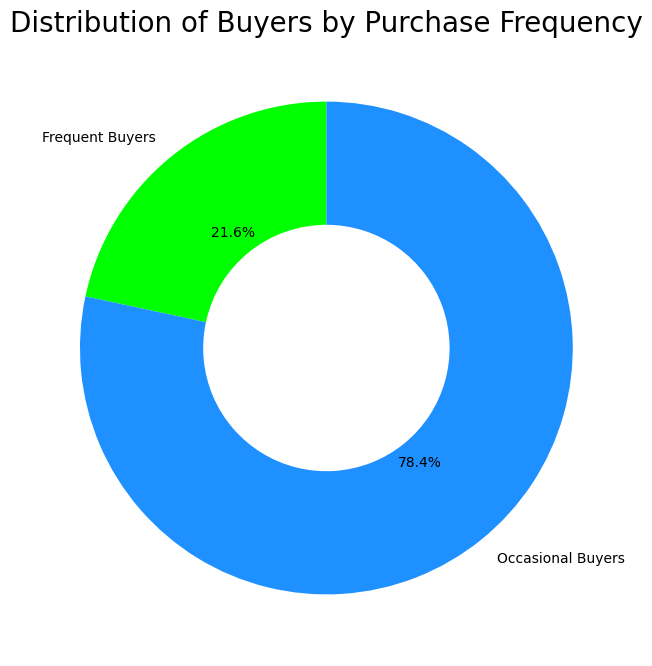

In [14]:
# Establishing connection to the database
connection = sqlite3.Connection('electronics_sales_data.db')
# Creating a DataFrame
df = pd.read_sql_query(query, connection)

# Accessing values in a DataFrame
data = {'frequent buyers':  df['frequent_buyers'][0],
        'occasional buyers':df['occasional_buyers'][0]}

plt.figure(figsize=(12, 8))
plt.pie(data.values(),
        labels=['Frequent Buyers', 'Occasional Buyers'],
        colors=['lime', 'dodgerblue'],
        autopct='%1.1f%%',
        startangle=90, wedgeprops=dict(width=0.5))
plt.title('Distribution of Buyers by Purchase Frequency',
          fontsize=20)
plt.show()